<a href="https://colab.research.google.com/github/dclark18/7331DataMiningNotebooks/blob/master/lab2/Lab2_DC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Data Mining 7331 - Spring 2020**

## Lab 2 - Classification

#### Daniel Clark, Joe Schueder, Jeff Washburn, Armando Vela


### Introduction

The Iowa Liquor Sales dataset is an API from Google’s Bigquery which contains the wholesale purchases by retail stores in the Iowa area. The dataset includes the spirit purchase details by product, date of purchase, and location the item was purchased from an Iowa Class “E” liquor license holder (retail stores). The time frame of this data starts from January 1, 2012 through December 31, 2019. As part of the study commissioned by the Iowa Department of Commerce, all alcoholic sales within the state were logged into the Department system, and in turn, published as open data by the State of Iowa. The dataset contains detail on the name, product, quantity and location of the individual container or package sale between the wholesaler (vendor) and the retailer.

### Data Description

The initial data set was 4.63GB with 17.7 million rows. We subsetted that down to 400k rows using a random set of data from the 2019 sales data. This work was done in our initial processing from earlier.

So taking our initial processing that was done from previous work, we further refined the 400k dataset by one-hot encoding the categorical features for sales month, liquor categories, and the stores. The stores will not be used in this analysis; however, it was still one-hot encoded for future analysis

It's also worth noting, that we used the log transformed values for sales dollars, cost per liter, state bottle cost and volume sold in liters along with the liquor catogory to focus on our classification and ensure that outliers do not hold too heavy of a weight in our analysis. 


In [2]:
import pandas as pd

url_dataset = 'https://raw.githubusercontent.com/jjschueder/7331DataMiningNotebooks/master/Live%20Assignments/df1hotmerge2.csv'
data = pd.read_csv(url_dataset)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 68 columns):
Unnamed: 0                  400000 non-null int64
pack                        400000 non-null int64
bottle_volume_ml            400000 non-null int64
state_bottle_cost           400000 non-null float64
state_bottle_retail         400000 non-null float64
bottles_sold                400000 non-null int64
sale_dollars                400000 non-null float64
volume_sold_liters          400000 non-null float64
volume_sold_gallons         400000 non-null float64
counter                     400000 non-null int64
liquor_category             400000 non-null object
store_parent                400000 non-null object
month                       400000 non-null object
year                        400000 non-null int64
monthyear                   400000 non-null object
liquor_category_AMARETTO    400000 non-null int64
liquor_category_BRANDY      400000 non-null int64
liquor_category_GIN      

Here you can see that we have 400,000 non null objects one-hot encoded to include month, year, store name and alcohol type. For our previous classification analysis, we dropped the liquor category and all the liquor types and just used the binary classification for Whiskey and Non-Whiskey. With 1 representing whether the liquor type was whiskey and 0 representing a non whiskey. 

### Project Requirements

####Data Preparation (15 points total)

• Define and prepare your class variables. Use proper variable
representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for
dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for
the analysis.

• Describe the final dataset that is used for classification/regression (include a
description of any newly formed variables you created)

####Modeling and Evaluation (70 points total)

• Choose and explain your evaluation metrics that you will use (i.e., accuracy,
precision, recall, F-measure, or any metric we have discussed). Why are the measure(s)
appropriate for analyzing the results of your modeling? Give a detailed explanation
backing up any assertions.

• Choose the method you will use for dividing your data into training and
testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why
your chosen method is appropriate or use more than one method as appropriate.

• Create three different classification/regression models (e.g., random forest,
KNN, and SVM). Two modeling techniques must be new (but the third could be SVM or
logistic regression). Adjust parameters as appropriate to increase generalization
performance using your chosen metric.

• Analyze the results using your chosen method of evaluation. Use
visualizations of the results to bolster the analysis. Explain any visuals and analyze why
they are interesting to someone that might use this model.

• Discuss the advantages of each model for each classification task, if any. If
there are not advantages, explain why. Is any model better than another? Is the
difference significant with 95% confidence? Use proper statistical comparison methods.

• Which attributes from your analysis are most important? Use proper
methods discussed in class to evaluate the importance of different attributes. Discuss
the results and hypothesize about why certain attributes are more important than others
for a given classification task.


####Deployment 

• How useful is your model for interested parties (i.e., the companies or
organizations that might want to use it for prediction)? How would you measure the
model's value if it was used by these parties? How would your deploy your model for
interested parties? What other data should be collected? How often would the model
need to be updated, etc.? 


####Exceptional Work 
• You have free reign to provide additional modeling.

• One idea: grid search parameters in a parallelized fashion and visualize the
performances across attributes. Which parameters are most significant for making a
good model for each classification algorithm?

## Data Preparation Part 1

We obtained a dataset on Iowa Liquor Sales from Google Bigquery. The aim of recording the data set is for the state to track alcohol and liquor sales from wholesalers and retailers from the year 2012 through 2019. You can see some Exploratory Data Analysis of this dataset below: 

https://github.com/jjschueder/7331DataMiningNotebooks/blob/master/lab1/msds7331_clark_schueder_vela_washburn.ipynb



In [5]:
# Import all necessary libraries we will be using in our dataset

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import sklearn
import statistics
import random

from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile, RFE, SelectFromModel

from sklearn.preprocessing import StandardScaler, Binarizer

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, auc, roc_curve
from IPython.display import display, HTML

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit, StratifiedShuffleSplit

from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor,AdaBoostClassifier,RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

matplotlib.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

print(data.shape)
data.head()

(400000, 68)


,Unnamed: 0,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,counter,liquor_category,store_parent,month,year,monthyear,liquor_category_AMARETTO,liquor_category_BRANDY,liquor_category_GIN,liquor_category_LIQUEUR,liquor_category_Other,liquor_category_RUM,liquor_category_SCHNAPPS,liquor_category_TEQUILA,liquor_category_VODKA,liquor_category_WHISKY,store_parent_CVS,store_parent_Caseys,store_parent_Hy-Vee,store_parent_Kum&Go,store_parent_Other,store_parent_QuikTrip,store_parent_SamsClub,store_parent_SmokingJoes,store_parent_Target,store_parent_Wal-Mart,store_parent_Walgreens,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,year_2019,monthyear_Apr-2019,monthyear_Aug-2019,monthyear_Dec-2019,monthyear_Feb-2019,monthyear_Jan-2019,monthyear_Jul-2019,monthyear_Jun-2019,monthyear_Mar-2019,monthyear_May-2019,monthyear_Nov-2019,monthyear_Oct-2019,monthyear_Sep-2019,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,grossmargin
0,0,20,375,3.85,5.78,20,115.60,7.50,1.98,1,Other,Other,Nov,2019,Nov-19,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,4.750136,15.413333,2.735233,1.348073,2.995732,2.014903,0.333910
1,1,8,50,8.75,13.13,1,13.13,0.05,0.01,1,Other,Other,Nov,2019,Nov-19,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,2.574900,262.600000,5.570632,2.169054,0.000000,-2.995732,0.333587
2,2,12,1000,16.50,24.75,6,148.50,6.00,1.58,1,GIN,Hy-Vee,May,2019,May-19,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,5.000585,24.750000,3.208825,2.803360,1.791759,1.791759,0.333333
3,3,6,750,21.17,31.76,24,762.24,18.00,4.75,1,WHISKY,Hy-Vee,Nov,2019,Nov-19,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,6.636261,42.346667,3.745890,3.052585,3.178054,2.890372,0.333438
4,4,6,1750,9.31,13.97,12,167.64,21.00,5.54,1,Other,Hy-Vee,Nov,2019,Nov-19,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,5.121819,7.982857,2.077296,2.231089,2.484907,3.044522,0.333572


**Our data Preparation includes the folloiwng layout**

*   Since we are predicting our liquor category type (opening to the entire list of categories and not just one), we can assign them a numerical value.
* Create new variables using aggredate data on profit, total cost and revenue
*   Since we transformed a number of continuous variables, we can drop them so that we are working directly on our normalized data




In [10]:
# Since we are predicting our liquor category type (opening to the entire list of categories and not just one), we can assign them a numerical value.

print (data['liquor_category'].unique())

df = pd.DataFrame({'col_1':[133,255,36,477,55,63]})
d = {'1':'M', '2': 'C', '3':'a', '4':'f', '5':'r', '6':'s'}
def ifef(col):
    col = str(col)
    return d[col[0]]

df['id_label'] = df['col_1'].apply(ifef)
print(df)

d = {'O':'1', 'G': '2', 'W':'3', 'T':'4', 'L':'5', 'V':'6', 'R':'7', 'S': '8', 'A':'9', 'B':'10'}

#data['id_label'] = data['liquor_category'].apply(ifef)

data['id_label'] = data['liquor_category'].astype(str).str[0].map(d)

print(data.head())

['Other' 'GIN' 'WHISKY' 'TEQUILA' 'LIQUEUR' 'VODKA' 'RUM' 'SCHNAPPS'
 'AMARETTO' 'BRANDY']
   col_1 id_label
0    133        M
1    255        C
2     36        a
3    477        f
4     55        r
5     63        s
   Unnamed: 0  pack  ...  grossmargin  id_label
0           0    20  ...     0.333910         1
1           1     8  ...     0.333587         1
2           2    12  ...     0.333333         2
3           3     6  ...     0.333438         3
4           4     6  ...     0.333572         1

[5 rows x 69 columns]


In [0]:
# Create new variables using aggredate data on profit, total cost and revenue

#do some calculations for cost and profit
data['profit'] = data['state_bottle_retail']*data['bottles_sold'] - data['state_bottle_cost']* data['bottles_sold']
data['profit_trans']= np.log(data['profit'])

data['totalcost'] = data['state_bottle_cost']* data['bottles_sold']
data['totalcost_trans']= np.log(data['totalcost'])

data['revenue'] = data['state_bottle_retail']*data['bottles_sold']
data['revenue_trans']= np.log(data['revenue'])

data['bottle_volume_ml_trans']= np.log(data['bottle_volume_ml'])


(400000, 12)


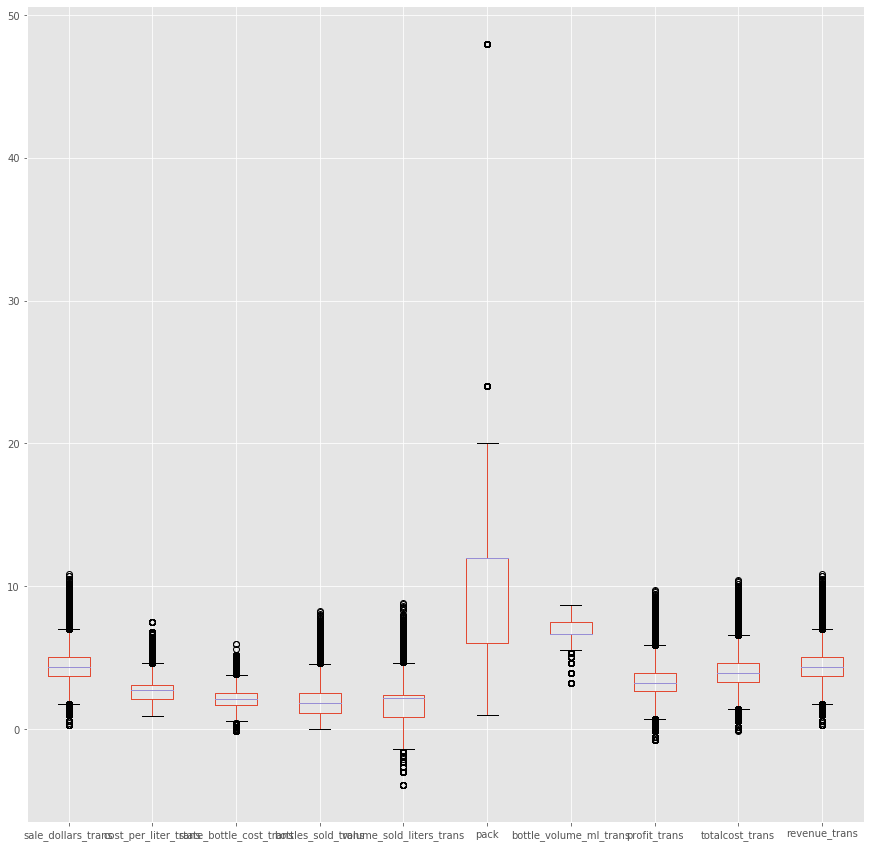

In [16]:
# Since we transformed a number of continuous variables, we can drop them so that we are working directly on our normalized data


# Remove unwanted columns, which include all the specific liquor categories, 
# except for liquor_category_WHISKY since that is what we want to classify on, along
# with all the store_ attributes
"""
cat_vars=['counter', 'liquor_category', 'store_parent',
 'month', 'year', 'monthyear', 'liquor_category_AMARETTO', 'liquor_category_BRANDY', 'liquor_category_GIN', 
 'liquor_category_LIQUEUR', 'liquor_category_Other', 'liquor_category_RUM', 'liquor_category_SCHNAPPS', 
 'liquor_category_TEQUILA', 'liquor_category_VODKA', 'month_Apr', 'month_Aug', 'month_Dec', 'month_Feb',
 'month_Jan', 'month_Jul', 'month_Jun', 'month_Mar', 'month_May', 'month_Nov', 'month_Oct', 'month_Sep', 
 'store_parent_CVS', 'store_parent_Caseys', 'store_parent_Hy-Vee', 'store_parent_Kum&Go', 
 'store_parent_Other', 'store_parent_QuikTrip', 'store_parent_SamsClub', 'store_parent_SmokingJoes', 
 'store_parent_Target', 'store_parent_Wal-Mart', 'store_parent_Walgreens']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
"""
#keep our transformed detail, along with the timing and store name detail

to_keep=['sale_dollars_trans', 'cost_per_liter_trans', 'store_parent',
      'state_bottle_cost_trans', 'bottles_sold_trans',
       'volume_sold_liters_trans','pack', 'bottle_volume_ml_trans', 
       'profit_trans', 'totalcost_trans', 'revenue_trans', 'id_label']
data_final=data[to_keep]
data_final.columns.values

#boxplot of all the variables
plt.figure(figsize=(15, 15))
ax = data_final.boxplot()
#ax.set_yscale('log')

print(data_final.shape)


From the standpoint of the boxplots, we can see that we have some uniformity in our continuous features with minimal outliers. To help us accurately predict our liquor categires, this will be helpful in us using these features build versious models to compare performance. Running a quick shape feature, we can see that we are not missing any data.

In [21]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 12 columns):
sale_dollars_trans          400000 non-null float64
cost_per_liter_trans        400000 non-null float64
store_parent                400000 non-null object
state_bottle_cost_trans     400000 non-null float64
bottles_sold_trans          400000 non-null float64
volume_sold_liters_trans    400000 non-null float64
pack                        400000 non-null int64
bottle_volume_ml_trans      400000 non-null float64
profit_trans                399996 non-null float64
totalcost_trans             400000 non-null float64
revenue_trans               400000 non-null float64
id_label                    400000 non-null object
dtypes: float64(9), int64(1), object(2)
memory usage: 36.6+ MB


Running a quick df describe, we can se that almost all of our variables are floats to account for the transformations. With the id_label and store_parents being object features used as our classifiers we are looking to use in our datasets. The last feature pack is represented as an int, which makes sense because they are typically sold in packs of 6, 12, 24 and 48.

## Data Preparation Part 2

To describe our final dataset 

In [22]:
data_final.describe()

,sale_dollars_trans,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,pack,bottle_volume_ml_trans,profit_trans,totalcost_trans,revenue_trans
count,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,399996.000000,400000.000000,400000.000000
mean,4.342939,2.766402,2.090235,1.847176,1.576537,11.950140,6.637246,3.244949,3.937411,4.343124
std,1.061412,0.828823,0.707591,1.078662,1.352197,8.382596,0.800586,1.061510,1.061492,1.061497
min,0.292670,0.916291,-0.116534,0.000000,-3.912023,1.000000,3.218876,-0.798508,-0.116534,0.292670
25%,3.727619,2.090805,1.690096,1.098612,0.810930,6.000000,6.620073,2.629007,3.322154,3.727619
50%,4.319087,2.736221,2.111425,1.791759,2.197225,12.000000,6.620073,3.222071,3.912823,4.319087
75%,5.030046,3.097687,2.539237,2.484907,2.351375,12.000000,7.467371,3.931826,4.624384,5.030046
max,10.823499,7.495542,5.926899,8.237479,8.797095,48.000000,8.699515,9.725413,10.417771,10.823499


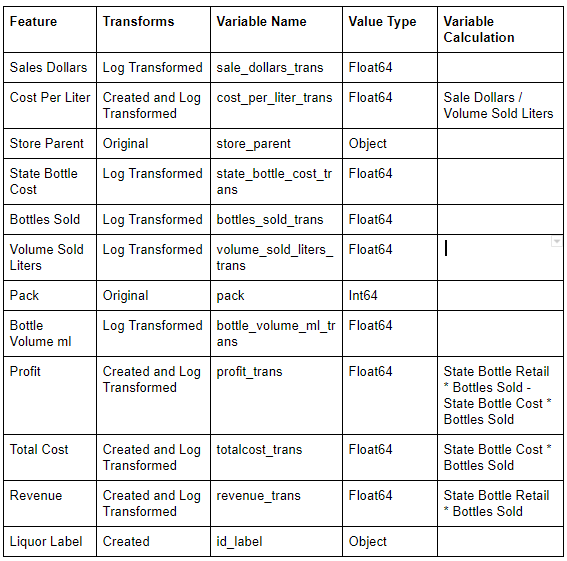


In [24]:
data_final.shape

(400000, 12)

Our final data set includes 12 features and 400,000 entries. 

##Modeling and Evaluation 1

The purpose of this Model is to build a classifier of the alcohol category and detirmine the sales and item measures that play the most weight into predicting the correct alcohol category. 

An ROC curve, also known as a Reciever Operation Characteristic Curve is a plot that calculates and can be used to compare the classifiers we will use in our modeling along with the true positive rate (TPR) and false positive rate (FPR) they convey. From a topline level, you can use the Area Under the Curve (AUC) to help detirmine which can better pair an observation with the correct liquor cateogry. An AUC score of 1.0 denotes a perfect classifier and an area of 0.5 represents a model is no better than a random guess.

In addition to the ROC-AUC value we will use to evaluate classifiers, we will be using other evaluators as well. 

**Accuracy** - Accuracy is the total number of correct predictions over the total number of predictions made. Accuracy will be plotted in our AUC curve and, while not perfect, is a good singlular measure to evaluate a model. Just be careful that we aren't overclassifying unbalalnced variables. 

Accuracy = (TP + TN)/(TP + FP + FN + TN)

**Precision** - Precision is the Proportions of true positives over the total number of positive outcomes whether accurately predicted or inaccurately predicted. 

Precision = (TP) / (TP + FP)





